# Mushrooms classification - Tensorflow

This notebook is used to build and train a binary classification neural network. We will train it for the [Kaggle - Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification) project. The data should be already processed and saved to .npy files. See the `mushrooms_data_preparation.ipynb` notebook from this repository to process the data.

### Import used modules

The only external modules used for this notebook are [numpy](http://www.numpy.org/), [tensorflow](https://www.tensorflow.org/), and [matplotlib](https://matplotlib.org/).

In [1]:
%matplotlib inline

import sys
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

SCRIPT_DIR = Path.cwd()
sys.path.append(str(SCRIPT_DIR.parent))

from data_utils.data_iterator import DataIterator

## Load the processed data

First we need to load the processed data. This files are loaded as numpy arrays.

In [2]:
training_data = np.load(open("training_data/mushrooms_training_data.npy", 'rb'))
training_labels = np.load(open("training_data/mushrooms_training_labels.npy", 'rb'))
validation_data = np.load(open("training_data/mushrooms_validation_data.npy", 'rb'))
validation_labels = np.load(open("training_data/mushrooms_validation_labels.npy", 'rb'))
test_data = np.load(open("training_data/mushrooms_test_data.npy", 'rb'))
test_labels = np.load(open("training_data/mushrooms_test_labels.npy", 'rb'))

Print data type and arrays shapes.

In [3]:
print("Loaded data type = {}".format(type(training_data)))
print("Training data shape = {}".format(training_data.shape))
print("Training labels shape = {}".format(training_labels.shape))
print("Validation data shape = {}".format(validation_data.shape))
print("Validation labels shape = {}".format(validation_labels.shape))
print("Test data shape = {}".format(test_data.shape))
print("Test labels shape = {}".format(test_labels.shape))


Loaded data type = <class 'numpy.ndarray'>
Training data shape = (6500, 117)
Training labels shape = (6500, 1)
Validation data shape = (812, 117)
Validation labels shape = (812, 1)
Test data shape = (812, 117)
Test labels shape = (812, 1)


## Create model

Now we will define our neural network model. We will create a tensorflow graph that we can later train. This graph should have:
- **Placeholders**: These are the model inputs. When training or evaluating the model, we will feed the graph through this operations with out data.
- **Hidden layers**: In this model we will use a stack of [fully connected layers](https://www.tensorflow.org/api_docs/python/tf/layers/dense). The number, size and activation function of this layers can be changed from the model parameters variables.
- **Output layer**: We will use a fully connected layer, with size 1 (one neuron) and a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function (the standart output function for binary classification).
- **Cost computation**: We need a tensorflow operation to calculate the cost of the current model prediction, with respect to the real labels. We will use the [logarithmic loss](https://datawookie.netlify.com/blog/2015/12/making-sense-of-logarithmic-loss/) for this task.
- **Training operations**: This tensorflow operations will be used to perform one training step (gradients calculation and parameters update) so the model decrease the cost.
- **Summaries**: We will add [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) summaries to vizualize the model graph (architecture), the training process, and some parameters of the model.
- **Metrics**: We will add operations to check the performance of the model with respect to the true labels we are trying to predict.

### Model parameters

This parameters are used to easily change the model architecture to try different configurations and find the best for our specific task.

In [4]:
# Parameters
fully_connected_layers = 3
fully_connected_size = 50
fully_connected_activation = tf.nn.relu

### Create placeholders

The placeholders are created using the data shapes. The first dimension is `None`, because this is the batch size, and we want to change it for different runs.

In [5]:
# Data inputs
x = tf.placeholder(dtype=tf.float32, shape=[None, training_data.shape[1]], name="inputs")
print(x)
# Labels inputs
y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="labels")
print(y)

# Learning rate input
learning_rate_input = tf.placeholder(dtype=tf.float32, shape=[], name="learning_rate")
print(learning_rate_input)

# Used in training to keep track of variables updates
global_step = tf.get_variable(name="global_step",
                              shape=[],
                              dtype='int32',
                              initializer=tf.constant_initializer(0),
                              trainable=False)
print(global_step)

Tensor("inputs:0", shape=(?, 117), dtype=float32)
Tensor("labels:0", shape=(?, 1), dtype=float32)
Tensor("learning_rate:0", shape=(), dtype=float32)
<tf.Variable 'global_step:0' shape=() dtype=int32_ref>


### Create hidden layers

In [6]:
dense_layers = fully_connected_layers

# Create first dense layer
# Shape: (batch_size, fully_connected_size)
dense = tf.layers.dense(x,
                        units=fully_connected_size,
                        activation=fully_connected_activation,
                        name="dense_1")

dense_layers -= 1
dense_layer_count = 2

# Create next dense layers
for i in range(dense_layers):
    # Shape: (batch_size, fully_connected_size)
    dense = tf.layers.dense(dense,
                            units=fully_connected_size,
                            activation=fully_connected_activation,
                            name="dense_{}".format(dense_layer_count))

    dense_layer_count += 1

### Create output layer

In [7]:
# Shape: (batch_size, 1)
output_layer = tf.layers.dense(dense, 
                               units=1, 
                               activation=tf.nn.sigmoid,
                               name="output")

### Cost and Optimizer

Now we create the tensorflow operations to calculate the cost of the model and perform one training step. We will use gradient descent to optimize our model.

In [8]:
with tf.variable_scope("cost_and_optimizer"):
    
    # Loss value for the model output of each data point fed to the graph
    # Shape: (batch_size, 1)
    loss_op = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,
                                                      logits=output_layer,
                                                      name="loss_op")
    
    # Cost value for all the data points fed to the model
    # Shape: ()
    cost = tf.reduce_sum(loss_op, name="cost")
    
    # Model optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_input,
                                                 name="gradient_descent_optimizer")
    
    # Trining operation. Perform one parameters update. Increment global_step by 1.
    training_op = optimizer.minimize(cost, global_step=global_step)

## Model metrics

In [9]:
# The model ouputs a value between 0 and 1. We need to transform 
# it to the predicted label (0 or 1)
predictions = tf.round(output_layer, name="predictions")

# Metrics
with tf.name_scope("metrics"):
    # Get the model accuracy.
    # Shape: (batch_size,)
    accuracy = tf.metrics.accuracy(labels=y,
                                   predictions=predictions,
                                   name="accuracy")

### Tensorboard summaries

In [10]:
tensorboard_logs_dir = Path(Path.cwd(), "tensorboard_logs")
tensorboard_logs_dir.mkdir(exist_ok=True)

with tf.name_scope("summaries"):
    tf.summary.scalar("cost", cost)
    tf.summary.scalar("accuracy", accuracy[0])
    tf.summary.histogram("output_layer", output_layer)
    summary_op = tf.summary.merge_all()

## Model training

Now it's time to train the model!

We will feed the data to the graph, one batch at a time. We will perform a parameters update each time we feed a batch ([mini batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)).

Every some training steps, we will evaluate the model on the validation data, to check how the model is performing on data not used for training.

### Training hyperparameters

These are the hyperparameters we need to tune in order to get the model and training to work. Try different values to see how the training and model performance change.

In [11]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.001

### Create lists of batchs

The batches are generated using the DataIterator of this repository. It outputs a batch of the required size at a time. It can shuffle the data before creating the batches, so the composition of each batch is different for each epoch (full pass over the entire training data).

In [12]:
training_iterator = DataIterator(data=training_data,
                                 labels=training_labels,
                                 batch_size=batch_size,
                                 shuffle=True)

validation_iterator = DataIterator(data=validation_data,
                                   labels=validation_labels,
                                   batch_size=batch_size,
                                   shuffle=True)

### Training operations

Now that we have the model graph, the training operations, and the data batch generators, we can train the model.

In [13]:
## Useful variables
# Validate the model every some global steps and print information
val_period = 10
# Save the model to file every some global steps
save_period = 20

In [14]:
# Tensorboard files
tensorboard_job_name = "dl_{}-ds_{}-lr_{}-e_{}-b_{}".format(fully_connected_layers,
                                                            fully_connected_size,
                                                            learning_rate,
                                                            epochs,
                                                            batch_size)
tensorboard_log_dir = Path(tensorboard_logs_dir, tensorboard_job_name)

# This tensorflow operations are used to initialize all the variables of the model.
init_op = tf.global_variables_initializer()
init_l_op = tf.local_variables_initializer()

global_step_count = 0

with tf.Session() as sess:
    
    # Initialize graph variables
    sess.run(init_op)
    sess.run(init_l_op)
    
    # Training and validation Tensorboard files writers
    train_writer = tf.summary.FileWriter(str(Path(tensorboard_log_dir, "train")),
                                         sess.graph)
    validation_writer = tf.summary.FileWriter(str(Path(tensorboard_log_dir, "validation")),
                                              sess.graph)
    
    # Set up a Saver for periodically serializing the model
    saver = tf.train.Saver(max_to_keep=5)
    
    # Create list to store usefull data
    training_costs = []
    training_accuracies = []
    validation_costs = []
    validation_accuracies = []
    
    # Iterate over the entire data
    for epoch in range(epochs):
        
        # Iterate over a generator that returns batches
        for train_batch in training_iterator:
            
            global_step_count = sess.run(global_step)
            
            feed_dict = {x: train_batch[0],
                         y: train_batch[1],
                         learning_rate_input: learning_rate}
            
            # Do a gradient update, and log results to Tensorboard               
            train_cost, train_accuracy, _, train_summary = sess.run(
                [cost, accuracy, training_op, summary_op],
                feed_dict=feed_dict)
            train_writer.add_summary(train_summary, global_step_count)
            
            training_costs.append(train_cost)
            training_accuracies.append(train_accuracy[0])
            
            # Evaluate the model on validation set every val_period steps
            if global_step_count % val_period == 0:
                
                val_batch_accuracies = []
                val_batch_costs = []
                
                # Evaluate on validation data
                for val_batch in validation_iterator:
                    
                    validation_feed_dict = {x: val_batch[0],
                                            y: val_batch[1]}
                    
                    val_batch_accuracy, val_batch_cost = sess.run(
                        [accuracy, cost],
                        feed_dict=validation_feed_dict)
                    
                    val_batch_accuracies.append(np.sum(val_batch_accuracy[0]))
                    val_batch_costs.append(np.sum(val_batch_cost))
                
                mean_val_accuracy = np.sum(np.array(val_batch_accuracies)) / validation_iterator.total_batches
                mean_val_cost = np.sum(np.array(val_batch_costs)) / validation_iterator.total_batches
                
                val_summary = tf.Summary(value=[
                    tf.Summary.Value(tag="val_summaries/accuracy",
                                     simple_value=mean_val_accuracy),
                    tf.Summary.Value(tag="val_summaries/cost",
                                     simple_value=mean_val_cost)])
                
                validation_writer.add_summary(val_summary, global_step_count)
                
                validation_costs.append(mean_val_cost)
                validation_accuracies.append(mean_val_accuracy)
                
                # Print information abuot training
                print("Epoch {} - Global step {} - Training cost {} - Training accuracy {} - "
                      "Validation cost {} - Validation accuracy {}".format(epoch,
                                                                           global_step_count,
                                                                           train_cost,
                                                                           train_accuracy[0],
                                                                           mean_val_cost,
                                                                           mean_val_accuracy))
            
            # Write a model checkpoint if necessary.
            if global_step_count % save_period == 0:
                save_path = saver.save(sess, "trained_models/model.ckpt")
                print("Model saved in path: {}".format(save_path))
    
    # Done training!
    print("Finished {} epochs!".format(epoch + 1))

Epoch 0 - Global step 0 - Training cost 86.42391967773438 - Training accuracy 0.0 - Validation cost 102.04003034319196 - Validation accuracy 0.5284465381077358
Model saved in path: trained_models/model.ckpt
Epoch 0 - Global step 10 - Training cost 86.95779418945312 - Training accuracy 0.5200764536857605 - Validation cost 99.37440708705357 - Validation accuracy 0.572688102722168
Epoch 0 - Global step 20 - Training cost 89.92535400390625 - Training accuracy 0.6281070709228516 - Validation cost 96.1207275390625 - Validation accuracy 0.6439230101449149
Model saved in path: trained_models/model.ckpt
Epoch 0 - Global step 30 - Training cost 82.78500366210938 - Training accuracy 0.6491395831108093 - Validation cost 93.92277308872768 - Validation accuracy 0.6587826865059989
Epoch 0 - Global step 40 - Training cost 85.2252197265625 - Training accuracy 0.6695745587348938 - Validation cost 91.35395159040179 - Validation accuracy 0.6779400280543736
Model saved in path: trained_models/model.ckpt
Ep

Model saved in path: trained_models/model.ckpt
Epoch 8 - Global step 430 - Training cost 62.822959899902344 - Training accuracy 0.9106784462928772 - Validation cost 75.25464739118304 - Validation accuracy 0.9109427588326591
Epoch 8 - Global step 440 - Training cost 59.82518768310547 - Training accuracy 0.9120818376541138 - Validation cost 75.19054303850446 - Validation accuracy 0.9123538562229702
Model saved in path: trained_models/model.ckpt
Epoch 8 - Global step 450 - Training cost 60.10016632080078 - Training accuracy 0.9134865403175354 - Validation cost 75.13241141183036 - Validation accuracy 0.9137419291904995
Epoch 9 - Global step 460 - Training cost 62.75225067138672 - Training accuracy 0.9148364067077637 - Validation cost 75.26555524553571 - Validation accuracy 0.91510009765625
Model saved in path: trained_models/model.ckpt
Epoch 9 - Global step 470 - Training cost 63.301246643066406 - Training accuracy 0.9160412549972534 - Validation cost 75.21884591238839 - Validation accurac

Model saved in path: trained_models/model.ckpt
Epoch 17 - Global step 910 - Training cost 63.39147186279297 - Training accuracy 0.9472974538803101 - Validation cost 73.83652169363839 - Validation accuracy 0.9473896026611328
Epoch 18 - Global step 920 - Training cost 62.245269775390625 - Training accuracy 0.9477182626724243 - Validation cost 73.81527273995536 - Validation accuracy 0.9478090831211635
Model saved in path: trained_models/model.ckpt
Epoch 18 - Global step 930 - Training cost 61.36833953857422 - Training accuracy 0.9481170177459717 - Validation cost 73.82691301618304 - Validation accuracy 0.9481829915727887
Epoch 18 - Global step 940 - Training cost 64.40220642089844 - Training accuracy 0.9485174417495728 - Validation cost 73.8135986328125 - Validation accuracy 0.9485975674220494
Model saved in path: trained_models/model.ckpt
Epoch 18 - Global step 950 - Training cost 61.12360382080078 - Training accuracy 0.9489245414733887 - Validation cost 73.78105817522321 - Validation ac

## Plot cost and accuracy during training

Now we plot the how the cost and accuracy change during training, for both the training data and the validation data. This information is also ploted in Tensorboard, but we plot it here anyways.

*Note: The training cost and accuracy is for one batch of data, but for the validation test, we plot the mean accuracy and cost over all the data batches.*

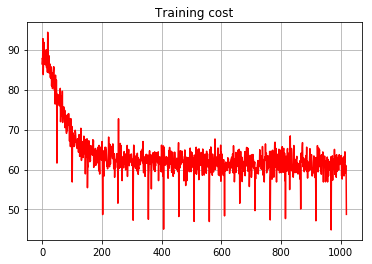

In [15]:
plt.plot(range(len(training_costs)), training_costs, color="red")
plt.title("Training cost")
plt.grid()

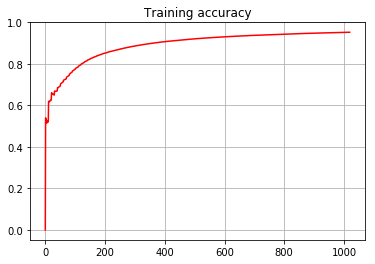

In [16]:
plt.plot(range(len(training_accuracies)), training_accuracies, color="red")
plt.title("Training accuracy")
plt.grid()

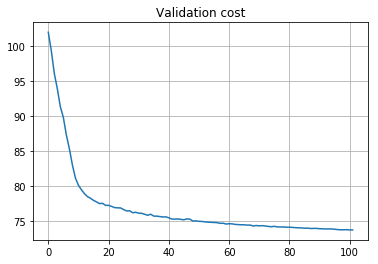

In [17]:
plt.plot(range(len(validation_costs)), validation_costs)
plt.title("Validation cost")
plt.grid()

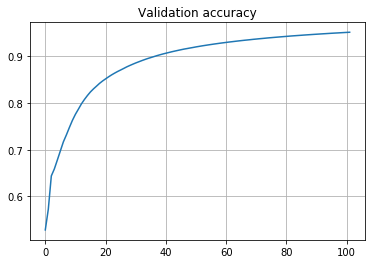

In [18]:
plt.plot(range(len(validation_accuracies)), validation_accuracies)
plt.title("Validation accuracy")
plt.grid()

## Tensorboard

To use tensorboard open a console, go to the project folder (`"mushrooms"`) type:

```bash
tensorboard --logdir tensoboard_logs\
```

### Tensoboard results

![output_layer_histograms](notebook_images/output_layer_histograms.png)
![graph](notebook_images/graph.png)